# Mel Frequency Cepstral Coefficients

## 1 Introduction

The first step in any speech recognition task is to extract features from the speech data  
Mel-Frequecy Cepstral Coefficients is one such example of a feature that is highly robust and used widely for various speech processing tasks  

MFCCs were first introduced in a 1980 paper by [Davis and Mermelstein](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.462.5073&rep=rep1&type=pdf)

We will now move on to implementing MFCCs from first principles so as to better understand how it can be used for various speech recognition and processing tasks

## 2 Setup
We first need to import the required Python libraries for the entire anaylsis  
Prerequisites required in this implementation are:
```
Python 2.7.x   
numpy   
scipy
matplotlib
```

You can invoke any required library into your workspace as:  
`import package_name`  

In [1]:
# Import Libraries
import numpy as np
import scipy.io.wavfile as wav
from scipy.fftpack import dct
import matplotlib.pyplot as plt

In [2]:
# Load the test audio signal
sample_rate, signal = wav.read('5_jackson_1.wav')

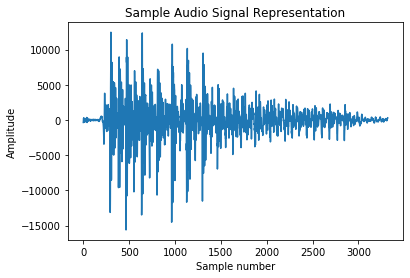

In [3]:
# Visualize the signal
plt.plot(signal)
plt.xlabel('Sample number')
plt.ylabel('Amplitude')
plt.title('Sample Audio Signal Representation')
plt.show()

## 1 Preprocessing

### 1.1 Pre-emphasis
Speech signals are generally band-limited to lower frequencies  
However, some higher frequencies are often distorted due to higher noise in these regions  
This helps improve the Signal-to-Noise Ratio (SNR) at higher frequencies  

Pre-emphasis is generally described by the following equation:  
`y(t) = x(t) - alpha*x(t)`  
Here alpha is the pre-emphasis coefficient  
Typical pre-emphasis coefficients are 0.95 or 0.97. Here we use `alpha=0.97`

In [4]:
# Pre-emphasis to ephasize higher frequencies
pre_emphasis = 0.97
emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

### 1.2 Framing

Performing a Fourier Transform on the signal directly will result in a loss of time-domain information  
Thus, to retain information in both domains we assume that frequency content is stationary for a short period of time (a window) and perform the Fourier Transform on these windows

Typical sizes for frames in speech processing is 20-40ms  
Typical length of frame overlap is 10-15ms  

We define `frame_size = 25ms` and `frame_stride = 10ms`. This represents an overlap of 15ms between frames

In [5]:
# Define framing constants
frame_size = 0.025 
frame_stride = 0.01

In [7]:
# Apply Framing

# Convert from seconds to samples
frame_length = frame_size*sample_rate 
frame_step = frame_stride*sample_rate  

signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))

print ('frame length : ', frame_length, 'samples')
print('frame stride : ', frame_step, 'samples')

# Make sure that we have at least 1 frame
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  

pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
# Pad Signal to make sure that all frames have equal number of samples without truncating any samples 
# from the original signal
pad_signal = np.append(emphasized_signal, z) 

# Generate indices of elements in each window
indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T

# Extract frames using indices
frames = pad_signal[indices.astype(np.int32, copy=False)]

frame length :  200 samples
frame stride :  80 samples


### 1.3 Windowing

A hamming window is applied to each frame to reduce the spectral leakage  
[Click Here](https://dspillustrations.com/pages/posts/misc/spectral-leakage-zero-padding-and-frequency-resolution.html) to better understand spectral leakage and its effects on calculation of a DFT

In [8]:
frames *= np.hamming(frame_length)

## 2 Fast Fourier Transform

We now calculate a 512-point FFT of each of the frames of the input audio signal  
Using the resultant data we get an idea of the constituent frequencies of each windowed instant, giving more information on the phonemes present at that instant, which can be used to identify speech syllables

In [9]:
# FFT
NFFT = 512  # 512 point FFT
mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

## 3 Filter Banks

Now a set of triangular filter banks `n_filt = 40` is applied to the power spectrum to convert it into a Mel-Scale  
The Mel-Scale is used to mimic the non-linear nature of human hearing - lower frequencies are picked up better than higher ones  
The conversion between Hz and Mel is given as:  
`m = 2595*log(1+ f/700)` 

In [10]:
# Filter banks
nfilt = 40

In [11]:
low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = np.floor((NFFT + 1) * hz_points / sample_rate)

fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right
    
    # Create triangular portion
    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])

# Apply Mel filter-banks to the power spectrum
filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * np.log10(filter_banks)  # dB

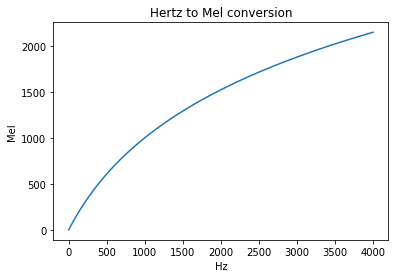

In [12]:
plt.plot(hz_points, mel_points)
plt.xlabel('Hz')
plt.ylabel('Mel')
plt.title('Hertz to Mel conversion')
plt.show()

It is evident from the above figure that there is greater resolution in the lower frequencies in the Mel-Scale and higher frequencies appear to be closer together  
Let us visualize the Mel-filterbanks:

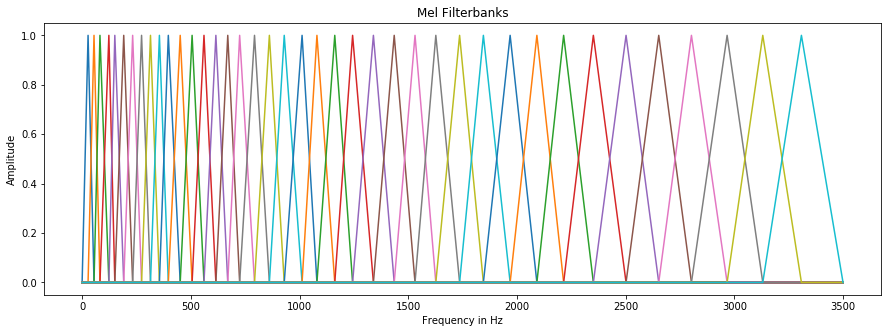

In [13]:
plt.rcParams['figure.figsize'] = [15, 5]
for i in range(nfilt):
    plt.plot(np.linspace(0, 3500, 257), fbank[i])

plt.xlabel('Frequency in Hz')
plt.ylabel('Amplitude')
plt.title('Mel Filterbanks')
plt.show()

## 4 Cepstral Coefficients

We now calculate Mel-Frequency Cepstral Coefficients (MFCCs) on the Filter-Banks  
As is evident from the filterbanks there is a high correlation between adjacent banks  
We therefore apply a [Discrete Cosine Transform](http://www.svcl.ucsd.edu/courses/ece161c/handouts/DCT.pdf) to the filterbanks for decorrelation. From the resulting Cepstral Coefficients, we use coefficients 2-13 as our MFCC features `num_ceps = 12`  
Higher cepstral coefficients are discarded as they represent very fast changes in speech. We can achieve similar results by considering only coefficients 2-13 as compared to all cepstral coefficients

In [14]:
# MFCC
num_ceps = 12
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13

## Mean Normalization (Optional)

To balance the power spectrum we cna additionally subtract the mean from each of the frames  
This has been shown to improve Signal-to-Noise Ratio (SNR)

In [15]:
filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)

In [16]:
mfcc -= (np.mean(mfcc, axis=0) + 1e-8)

In [17]:
def mfcc(filename):
    sample_rate, signal = scipy.io.wavfile.read(filename)
    pre_emphasis = 0.97
    emphasized_signal = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
    frame_size = 0.025 
    frame_stride = 0.01
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(numpy.ceil(float(numpy.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

    pad_signal_length = num_frames * frame_step + frame_length
    z = numpy.zeros((pad_signal_length - signal_length))
    pad_signal = numpy.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

    indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + numpy.tile(numpy.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(numpy.int32, copy=False)]
    
    frames *= numpy.hamming(frame_length)
    # FFT
    NFFT = 512  # 512 point FFT
    mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT))  # Magnitude of the FFT
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum
    # Filter banks
    nfilt = 40
    low_freq_mel = 0
    high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = numpy.dot(pow_frames, fbank.T)
    filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * numpy.log10(filter_banks)  # dB
    # MFCC
    num_ceps = 12
    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13
    filter_banks -= (numpy.mean(filter_banks, axis=0) + 1e-8)
    mfcc -= (numpy.mean(mfcc, axis=0) + 1e-8)
    return mfcc